#### Etapa 3 - Análise exploratória dos dados (EDA)

In [13]:
import pandas as pd
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import mannwhitneyu

warnings.filterwarnings(action='ignore')

In [14]:
df_athletes_activities = pd.read_csv('C:/Users/USER/Desktop/EstudosDados/Projetos/Corrida/physical_inactivity_prediction/scripts_prediction_model/final/st2_df_run_activities.csv')
df_run_activities_features = df_athletes_activities.drop(['athlete_id', 'activity_date', 'will_churn'], axis=1)
df_run_activities_features

,total_distance (km),total_time (min),pace (min/km),speed (km/h),weekly_frequency,days_since_last_run
0,3.61,23.0,6.37,9.42,2,0
1,5.84,41.0,7.02,8.55,1,8
2,4.28,32.0,7.48,8.02,2,1
3,7.52,50.0,6.65,9.02,1,30
4,7.51,51.0,6.79,8.84,1,9
...,...,...,...,...,...,...
719,10.06,45.0,4.47,13.26,3,3
720,5.20,33.0,6.35,9.27,3,2
721,12.10,62.0,5.12,11.71,3,3
722,4.08,22.0,5.39,11.13,2,5


In [15]:
# Teste de normalidade das features com Shapiro-Wilk
for column in df_run_activities_features:
    _, p_value = shapiro(df_run_activities_features[column].values)
    print(f'Coluna: {column}, p-value: {round(p_value, 5)}')

Coluna: total_distance (km), p-value: 0.0
Coluna: total_time (min), p-value: 0.0
Coluna: pace (min/km), p-value: 0.0
Coluna: speed (km/h), p-value: 0.0
Coluna: weekly_frequency, p-value: 0.0
Coluna: days_since_last_run, p-value: 0.0


In [16]:
# Análise de correlação das variáveis
corr = df_run_activities_features.corr()
corr

,total_distance (km),total_time (min),pace (min/km),speed (km/h),weekly_frequency,days_since_last_run
total_distance (km),1.000000,0.875546,-0.323465,0.511025,0.392560,-0.108243
total_time (min),0.875546,1.000000,0.037765,0.096352,0.253446,-0.081518
pace (min/km),-0.323465,0.037765,1.000000,-0.750706,-0.234806,0.062700
speed (km/h),0.511025,0.096352,-0.750706,1.000000,0.435427,-0.108077
weekly_frequency,0.392560,0.253446,-0.234806,0.435427,1.000000,-0.259736
days_since_last_run,-0.108243,-0.081518,0.062700,-0.108077,-0.259736,1.000000


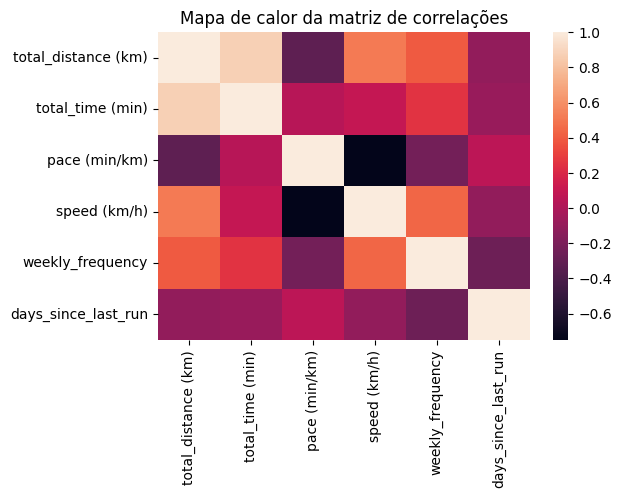

In [17]:
# Plot do mapa de calor da matriz de correlações
ax, fig = plt.subplots(figsize=[6,4])
sns.heatmap(corr)
plt.title('Mapa de calor da matriz de correlações')
plt.show()

In [18]:
# Teste de Mann-Whitney U para diferenciação das features em relação ao target
mannwhitneyu_dict = {
    "Feature": [],
    "p-value": []
}


for feature in df_run_activities_features.columns:
    sem_lesao = df_athletes_activities.loc[df_athletes_activities['will_churn'] == 0 , feature]
    com_lesao = df_athletes_activities.loc[df_athletes_activities['will_churn'] == 1 , feature]

    U1, p = mannwhitneyu(sem_lesao, com_lesao, method="auto")
    U2, p = mannwhitneyu(com_lesao, sem_lesao, method="auto")

    mannwhitneyu_dict["Feature"].append(feature)
    mannwhitneyu_dict["p-value"].append(p)

df_mannwhitneyu = pd.DataFrame(mannwhitneyu_dict).reset_index(drop = True)

df_mannwhitneyu['p-value Significante'] = df_mannwhitneyu['p-value'] < 0.05
df_mannwhitneyu

,Feature,p-value,p-value Significante
0,total_distance (km),2.576501e-05,True
1,total_time (min),7.576983e-03,True
2,pace (min/km),2.418370e-06,True
3,speed (km/h),2.398345e-07,True
4,weekly_frequency,6.615026e-14,True
5,days_since_last_run,3.680625e-10,True
